# **Proyecto 4: Faces in The Wild**
---

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

### 1. Librearias


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import math

from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

### 2. Configuración de gráfica

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda:0


In [3]:
# Apple mac silicon
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

print(f"Device: {device}")

Device: cpu


---
## **3. Funciones generales**

A continuación se define funciones generales encapsuladas en clases de ser necesario para mejorar la eficiencia del desarrollo de nuestro modelo, por ejemplo `ImageHandler` es una clase que alberga clases para poder interactuar con las imagenes de forma sencilla.

In [4]:
class ImageHandler:
    def __init__(self, image_path = "cropped_faces"):
        self.image_path = image_path

    def load_img(self, img_id):
        path = f"{self.image_path}/{img_id}.png"
        return Image.open(path)

    def plot_imgs(self, imgs, size = 3):
        img_number = imgs.shape[0]
        rows = cols = math.ceil(np.sqrt(img_number))
        fig = plt.figure(figsize=(rows*size, cols*size))
        for i in range(img_number):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(imgs[i])
            plt.axis('off')
        plt.show()

    def visualize_samples(self, loader, num_samples = 5, size = 3):
        rows = cols = math.ceil(np.sqrt(num_samples))
        fig = plt.figure(figsize = (rows*size, cols*size))
        for images1, images2, labels in loader:
            for i in range(num_samples):
                plt.subplot(rows, cols, i+1)
                image = images1[i].permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) to (H, W, C) and convert to numpy array
                plt.imshow(image)
                plt.axis('off')
            break
        plt.show()



---
## **3. Exploración del Dataset**

Procedemos a leer la información obtenida de nuestro dataset, de tal forma que nos encontramos con las columnas `image1_image2` y `label` que contienen el identificador de ambas imágenes a comparar y `label` para indicar si provienen del mismo rostro ó de distintos.

In [5]:
train_df = pd.read_csv("/kaggle/input/proyecto4-ml/train.csv")
test_df = pd.read_csv("/kaggle/input/proyecto4-ml/test.csv")

print("> Train data before image splitting and label encoder")
print(train_df.head())

print("\n> Test data before image splitting and label encoder")
print(test_df.head())

> Train data before image splitting and label encoder
  image1_image2 label
0     1485_4047  diff
1     5335_6055  same
2    10796_3696  same
3    11991_6672  same
4     7003_2539  same

> Test data before image splitting and label encoder
  image1_image2
0     6874_1599
1   11365_12931
2    10132_4581
3    4706_12001
4     3350_8318


Ahora notamos que nos conviene separar `image1_image2` en dos columnas distintas, de tal forma que podamos actuar con ellas de manera independiente, además de modificar el `label` para adoptar una tecnología de codificación, tal que para `diff` usemos $0$ y para `same` el valor de $1$ representando diferencia e igualdad respectivamente.   

In [6]:
train_df[["image1", "image2"]] = train_df["image1_image2"].str.split("_", expand=True)
test_df[["image1", "image2"]] = test_df["image1_image2"].str.split("_", expand=True)

train_df.drop(columns=["image1_image2"], inplace=True)
test_df.drop(columns=["image1_image2"], inplace=True)

train_df = train_df[["image1", "image2", "label"]]
train_df["label"] = pd.factorize(train_df["label"])[0]

In [7]:
print("> Train data before image splitting and label encoder")
print(train_df.head())

print("\n> Test data before image splitting and label encoder")
print(test_df.head())

> Train data before image splitting and label encoder
  image1 image2  label
0   1485   4047      0
1   5335   6055      1
2  10796   3696      1
3  11991   6672      1
4   7003   2539      1

> Test data before image splitting and label encoder
  image1 image2
0   6874   1599
1  11365  12931
2  10132   4581
3   4706  12001
4   3350   8318


Ahora vamos a indagar más a fondo en nuestro dataset para hallar métricas útiles en nuestra implementación, a pesar que contamos con pocos datos disponibles. Es así entonces que nuestro dataset de entrenamiento cuenta con $1100$ entradas para un label $0$ y $1$ mostrando un porcentaje balanceado dado pues que el dataset en total contiene $2200$ entradas. 

In [8]:
print(f"\n> Train data shape: {train_df.shape}")
print(f"> Test data shape: {train_df.shape}")

print("\n> Train data labels with 0:", train_df["label"].value_counts()[0])
print("> Train data labels with 1:", train_df["label"].value_counts()[1])

print("\n> Train data null values:", train_df.isnull().sum().sum())
print("> Test data null values:", test_df.isnull().sum().sum())


> Train data shape: (2200, 3)
> Test data shape: (2200, 3)

> Train data labels with 0: 1100
> Train data labels with 1: 1100

> Train data null values: 0
> Test data null values: 0


Por último, se procede a brindar un claro ejemplo de cómo se vería nuestra función de tratamiento de imágenes generales `ImageHandler()` cargando dos imágenes de nuestra base de datos en un caso donde existe similitud dado por el identificado $1347$. Para este caso nuestra imagen tiene un tamaño de `64x64` con $3$ canales.

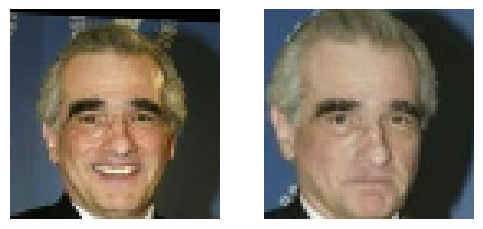

(64, 64, 3)

In [9]:
ih = ImageHandler("cropped_faces")

im1 = ih.load_img(train_df["image1"][134])
im2 = ih.load_img(train_df["image2"][134])

ih.plot_imgs(np.array([im1, im2]))
np.array(im1).shape

---
## **Modelo 1: Siamese CNN**

### **1.1 Data Loader for Siamese CNN**

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [10]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]

        img1 = ih.load_img(img1_id).convert("RGB")
        img2 = ih.load_img(img2_id).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if self.is_test:
            return img1, img2

        label = self.df.iloc[idx, 2]
        return img1, img2, torch.tensor(label, dtype=torch.float32)

A continuación se va a proceder con la implementación de nuestra clase custom dataset para manejar dos imágenes, lo que hará es brindarnos una estructura para los datos y un medio para aplicarle transformaciones, además se convierte en `RGB` para manejar una convención de canales. Retorna un formato entendible para PyTorch. Posteriormente, el DataLoader nos permite iterar el dataset en mini-lotes (batches) de manera paralela brindando un uso eficiente en el entrenamiento en GPU.

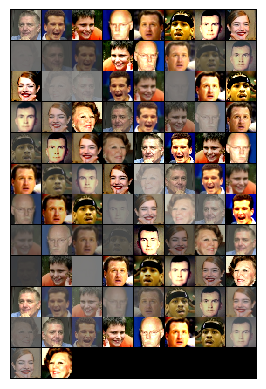

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.utils import make_grid
from torchvision import transforms

batch_size = 64

# Definir las transformaciones de augmentación de datos
data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=3,sigma=(0.1, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=1, saturation=0.2),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])


# Define validation/test transformations
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Train-Test split
train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=12)


# Initializing custom datasets with transformations
train_dataset = TwoImageDataset(train_subset_df, transform=data_augmentation_transforms)
val_dataset = TwoImageDataset(val_subset_df, transform=val_test_transforms)
test_dataset = TwoImageDataset(test_df, transform=val_test_transforms, is_test=True)

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)



def show_dataset(dataset, n=10):

    imgs = torch.stack([dataset[i][0] for _ in range(n)
                       for i in range(9)])
    grid = make_grid(imgs).numpy()
    plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')

show_dataset(train_dataset)

A continuación se inicia con la implementación de la red neuronal convolucional siamesa utilizando PyTorch,

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.embedding_size = embedding_size

        # Cargar ResNet50 pre-entrenado
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.conv1 = nn.Sequential(*list(resnet.children())[:-1])

        # fully connected layers, executed after resnet weights
        self.fc = nn.Sequential(
            # at the end of resnet there is 4096 flatten features per image
            nn.Linear(in_features = 4096, out_features = 4096, bias = True),
            nn.BatchNorm1d(4096), # normalize layer for median 0 and variance 1 (mitigate gradient error)
            nn.LeakyReLU(negative_slope = 0.01), # non-linear activation function, 
            #nn.Dropout(0.50),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(negative_slope = 0.01),
            #nn.Dropout(0.50),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x): # esta va ser la convolucion para cada imagen
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img1, img2):  # esta es la parte donde procesa cada imagen las concatena y las pasa por la red fully connected
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)

        concat = torch.cat((out1, out2), 1)

        output = self.fc(concat)
        output = torch.flatten(output)
        return output

    def train_cnn(self, train_loader, val_loader, loss_fn, optimizer, scheduler=None, num_epochs=5, patience=5):
        total_step = len(train_loader)
        list_loss = []
        val_loss = []
        best_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(num_epochs):
            self.train()
            epoch_loss = 0.0

            for i, (images1, images2, labels) in enumerate(train_loader):
                images1 = images1.to(device)
                images2 = images2.to(device)
                labels = labels.to(device)

                output = self(images1, images2)
                loss = loss_fn(output, labels)

                optimizer.zero_grad()
                loss.backward()  # Backward pass
                optimizer.step()

                epoch_loss += loss.item()
                list_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')

            avg_train_loss = epoch_loss / total_step
            avg_val_loss = self.evaluate(val_loader, loss_fn)
            val_loss.append(avg_val_loss)

            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(avg_val_loss)
                else:
                    scheduler.step()

            print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

            # Condicion para que se guarde el mejor modelo y se detenga el entrenamiento por el early stopping
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save(self.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print('Early stopping triggered.')
                    break

        print('Finished Training Trainset')
        self.load_state_dict(torch.load('best_model.pth'))
        return list_loss, val_loss 

    def evaluate(self, val_loader, loss_fn):  # esta es la parte donde se evalua el modelo y es usado para el early stopping
        y_pred = []
        running_loss = 0.0
        self.eval()
        with torch.no_grad():
            for image1, image2, labels in val_loader:
                image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
                output = self(image1, image2)
                loss = loss_fn(output, labels)
                running_loss += loss.item()
                output = output.cpu()
                pred = torch.round(output)
                y_pred.append(float(pred.item()))
        avg_val_loss = running_loss / len(val_loader)
        return avg_val_loss

    def predict(self, dataloader, with_labels=False):
        y_pred = []
        model.eval()
        with torch.no_grad():
            if not with_labels:  # Si no tiene labels: para el dataset de test
                for image1, image2 in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            else:  # si tiene labels: para el dataset de validacion
                for image1, image2, _ in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            return y_pred

In [13]:
import os

# Configurar max_split_size_mb a 128 MB
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

learning_rate = 0.0001
embedding_size = 2048  # no se usa
# Intanciando model
model = SiameseNetwork(embedding_size=embedding_size).to(device)

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.1)

In [14]:
epochs = 100
patience = 20 # Early stopping patience

# Entrenamiento del modelo0 train_loader, val_loader, loss_fn, optimizer, scheduler=None, num_epochs=5, patience=5)
list_loss, val_loss = model.train_cnn(train_dataloader, val_dataloader, loss_fn, optimizer, scheduler=scheduler, num_epochs=epochs, patience=patience )

Epoch 1, Training Loss: 0.8027, Validation Loss: 0.8302
Epoch 2, Training Loss: 0.7381, Validation Loss: 0.8314
Epoch 3, Training Loss: 0.5788, Validation Loss: 0.8196
Epoch 4, Training Loss: 0.5637, Validation Loss: 0.7992
Epoch 5, Training Loss: 0.5747, Validation Loss: 0.7974
Epoch 6, Training Loss: 0.5342, Validation Loss: 0.7851
Epoch 7, Training Loss: 0.5613, Validation Loss: 0.7854
Epoch 8, Training Loss: 0.5466, Validation Loss: 0.7950
Epoch 9, Training Loss: 0.5577, Validation Loss: 0.7975
Epoch 10, Training Loss: 0.5458, Validation Loss: 0.7917
Epoch 11, Training Loss: 0.5459, Validation Loss: 0.7864
Epoch 12, Training Loss: 0.5639, Validation Loss: 0.7965
Epoch 13, Training Loss: 0.5513, Validation Loss: 0.7863
Epoch 14, Training Loss: 0.5701, Validation Loss: 0.7934
Epoch 15, Training Loss: 0.5574, Validation Loss: 0.7992
Epoch 16, Training Loss: 0.5411, Validation Loss: 0.7936
Epoch 17, Training Loss: 0.5285, Validation Loss: 0.7912
Epoch 18, Training Loss: 0.5573, Validat

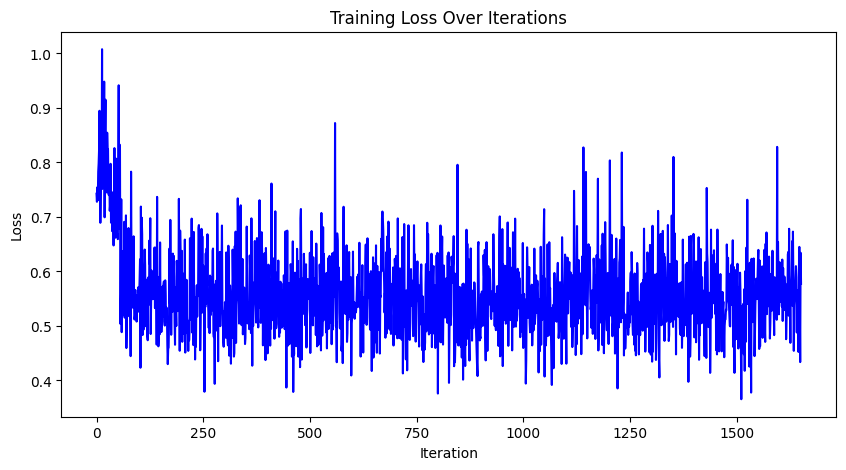

In [15]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label="Training Loss", color="blue")
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

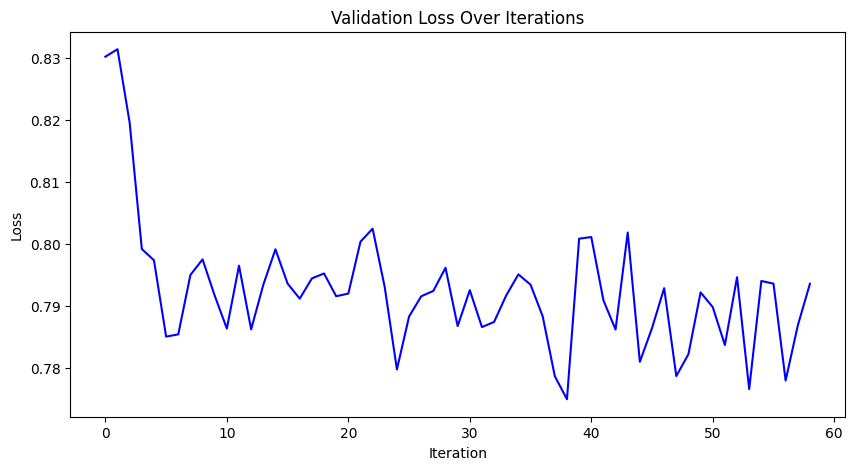

In [16]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(val_loss, label="Val Loss", color="blue")
plt.title("Validation Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       220
           1       0.58      0.57      0.57       220

    accuracy                           0.58       440
   macro avg       0.58      0.58      0.58       440
weighted avg       0.58      0.58      0.58       440



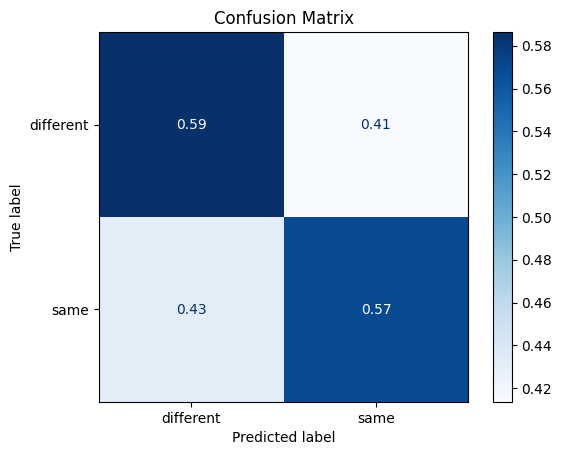

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_pred = model.predict(val_dataloader, with_labels=True)
cm = confusion_matrix(val_subset_df['label'], val_pred, normalize='true')

# Generate the classification report
report = classification_report(val_subset_df['label'], val_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['different', 'same'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
test_values = model.predict(test_dataloader)
print(np.unique(test_values))

[0 1]


In [19]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curve ROC(Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.show()

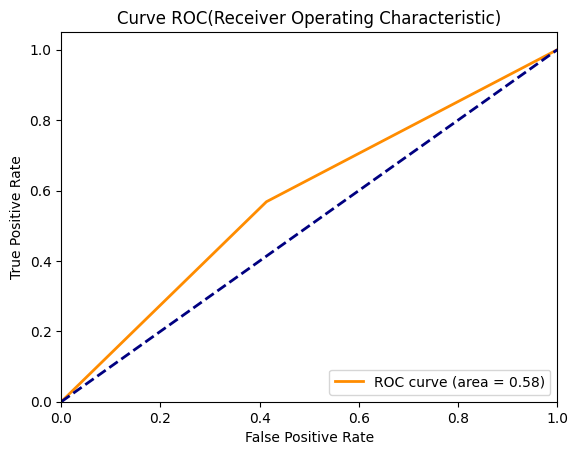

In [20]:
plot_roc_curve(val_subset_df['label'], val_pred)

---
## **Submission**

In [21]:
test_df_p4 = pd.read_csv("test.csv")  # Asegúrate de que tienes un archivo test.csv cargado

# Crear el DataFrame para la sumisión
submission_df = pd.DataFrame({
    'image1_image2': test_df_p4['image1_image2'],
    'label': ['same' if pred == 1 else 'diff' for pred in test_values]
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('submission_p4.csv', index=False)

print("Submission saved to submission_p4.csv")


Submission saved to submission_p4.csv
